<a href="https://colab.research.google.com/github/sizhky/.-rc/blob/master/ResNet_architecture-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torchsummary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import DataLoader, Dataset
from glob import glob
import cv2, numpy as np
import torchvision.transforms as transforms

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kishorea","key":"6ac21135e249b93f74d5cf4fb71a83ae"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
!kaggle datasets download -d tongpython/cat-and-dog

 92% 201M/218M [00:05<00:00, 35.1MB/s]
100% 218M/218M [00:05<00:00, 42.5MB/s]


In [0]:
!unzip cat-and-dog.zip

In [0]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

In [0]:
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] 
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)    
    return im.float().to(device), torch.tensor([target]).float().to(device)

In [0]:
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
def get_model():
 model = models.resnet18(pretrained=True)
 for param in model.parameters():
     param.requires_grad = False
 model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
 model.fc = nn.Sequential(nn.Flatten(),
 nn.Linear(512, 128),
 nn.ReLU(),
 nn.Dropout(0.2),
 nn.Linear(128, 1),
 nn.Sigmoid())
 loss_fn = nn.BCELoss()
 optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
 return model.to(device), loss_fn, optimizer

In [0]:
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [0]:
def get_data():     
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [0]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [0]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [0]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

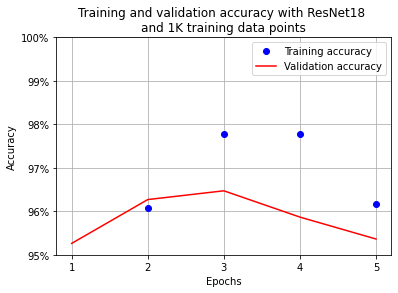

In [0]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
def get_model():
 model = models.resnet34(pretrained=True)
 for param in model.parameters():
     param.requires_grad = False
 model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
 model.fc = nn.Sequential(nn.Flatten(),
 nn.Linear(512, 128),
 nn.ReLU(),
 nn.Dropout(0.2),
 nn.Linear(128, 1),
 nn.Sigmoid())
 loss_fn = nn.BCELoss()
 optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
 return model.to(device), loss_fn, optimizer

In [0]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [0]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


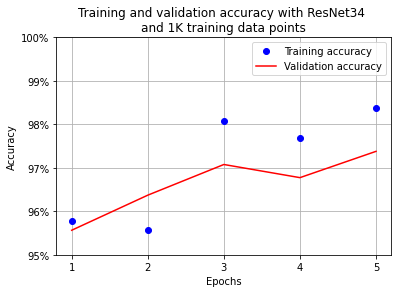

In [0]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet34 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
model = models.resnet50(pretrained=True).to(device)
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
def get_model():
 model = models.resnet50(pretrained=True)
 for param in model.parameters():
     param.requires_grad = False
 model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
 model.fc = nn.Sequential(nn.Flatten(),
 nn.Linear(2048, 128),
 nn.ReLU(),
 nn.Dropout(0.2),
 nn.Linear(128, 1),
 nn.Sigmoid())
 loss_fn = nn.BCELoss()
 optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
 return model.to(device), loss_fn, optimizer

In [0]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [0]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


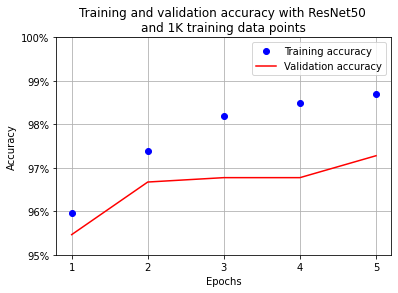

In [0]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet50 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
model = models.resnet101(pretrained=True).to(device)
summary(model, input_size = (3,224,224))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256

In [0]:
def get_model():
 model = models.resnet101(pretrained=True)
 for param in model.parameters():
     param.requires_grad = False
 model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
 model.fc = nn.Sequential(nn.Flatten(),
 nn.Linear(2048, 128),
 nn.ReLU(),
 nn.Dropout(0.2),
 nn.Linear(128, 1),
 nn.Sigmoid())
 loss_fn = nn.BCELoss()
 optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
 return model.to(device), loss_fn, optimizer

In [0]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [0]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


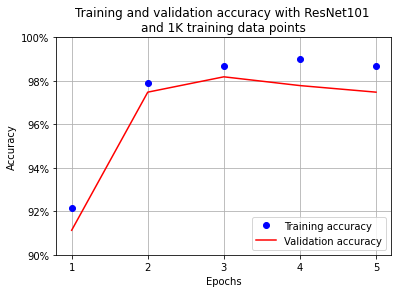

In [0]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet101 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.9,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
model = models.resnet152(pretrained=True).to(device)
summary(model, input_size = (3,224,224))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256

In [0]:
def get_model():
 model = models.resnet152(pretrained=True)
 for param in model.parameters():
     param.requires_grad = False
 model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
 model.fc = nn.Sequential(nn.Flatten(),
 nn.Linear(2048, 128),
 nn.ReLU(),
 nn.Dropout(0.2),
 nn.Linear(128, 1),
 nn.Sigmoid())
 loss_fn = nn.BCELoss()
 optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
 return model.to(device), loss_fn, optimizer

In [0]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [0]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


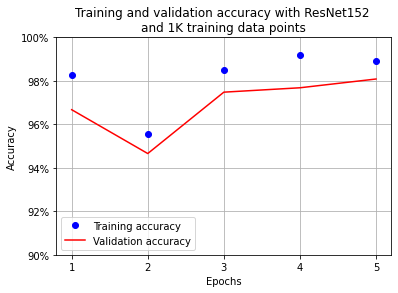

In [0]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet152 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.9,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
models.